<hr>

# Program plots profiles of state variables and process tendencies at various locations and times of ENSO phase

<ul>
<li> Level 1: Mean profiles of states and tendencies during ENSO phase (seasons: monthly means) </li>
<li> Level 2: Time varying profiles during a season or seasonal transtion </li>
<li> Level 3: Statistical reltiosnhips between vertical processes and ENSO/forcing/dynamical strength </li>
</ul>
<hr>

In [1]:

import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
#from dateutil.relativedelta import relativedelta


import cartopy.crs as ccrs
import pandas as pd
import dask as ds

import warnings
warnings.filterwarnings("ignore", message="FutureWarning")


In [2]:
# To Import My Functions ###
import vproc_func as mypy
import vproc_figs as myfigs
import vproc_case_desc as mycase
import importlib

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

In [4]:
cluster = NCARCluster(project='p03010039')
cluster.scale(9)
#cluster

/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, Future

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper1/proxy/34661/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper1/proxy/34661/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:42672,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/casper1/proxy/34661/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Initial Simulation Information

In [6]:

importlib.reload(mypy) # Required because I am constantly the .py files
importlib.reload(mycase) 
importlib.reload(myfigs) 

''''' Which case to use '''''

case_desc = []

''' ##### REVERT EXPERIMENTS ##### '''

#pref_out = 'cam6_revert'
#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i'])



#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'

#case_desc = ['rCE2i','rUW','rSB','rC5p','rM3','rclm4']
#case_desc = ['rCE2i','rUW','rSB','rC5p','rM3','rclm4']
#case_desc = ['rZMp','rpfrac']
#case_desc = ['rTMS']
#case_desc = ['rpremit']
#case_desc = ['rGW']
#case_desc = ['rnohertz']
#case_desc = ['rM3']

#case_desc = ['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc'] 
## Do not have. -- 'rZMc','rZMp','rpfrac','rTMS','rGW']
#case_desc = ['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc','rZMp','rpfrac','rTMS','rGW'] 

pref_out = 'c5_c6_ERA5'  
case_desc = ['C6','rC5']  
nrevert = len(case_desc)
case_type = ['cam6_revert']*nrevert



''' ##### SETTINGS INCLUDING ENSEMBLES ###### '''

#pref_out = 'lens1_divlev_test'    
#nens = 30

#case_desc = ['CE1.E%01d'%(itt) for itt in range(1,nens+1)]
#case_type  = ['lens1']*nens




#case_desc = ['CE2.E%01d'%(itt) for itt in range(1,nens+1)]
#case_type  = ['lens2']*nens

#case_desc = ['C6.E%01d'%(itt) for itt in range(1,nens+1)]
#case_type  = ['c6_amip']*nens



''' ###### REANAL+ABOVE MODEL SIMS ######## '''

#pref_out = 'reanal_all'


#case_reanal = ['ERA5','ERAI','CFSR','MERRA2','JRA25'] 
#type_reanal = ['reanal','reanal','reanal','reanal','reanal']

case_reanal = ['ERA5'] 
type_reanal = ['reanal']


reanal_climo = True # Grab climo. values for mean, Nino and nina events for reanalysis only




''' Stitch Cases Togther '''


#case_desc = np.array(case_reanal)
#case_type = np.array(type_reanal)


case_desc = np.array(case_desc+case_reanal)
case_type = np.array(case_type+type_reanal)


#case_desc = np.array(case_desc)
#case_type = np.array(case_type)


#case_desc = np.flip(case_desc)
#case_type = np.flip(case_type)






'''
    ## INDIVIDUAL CASE SETTINGS/ADDITIONS ##
'''





''''' Which nino SST region '''''
nino_region = 'nino34'




''' SEASON '''

seas_mons = np.array(["Jan","Feb","Dec"])

clim_anal = False

''''' Years for the analysis '''''

years_data = (1979,2005) # Year range of history files to read AND either 'climo' one file or 'tseries' many files


''' REGIONAL SPECS (LAT/LON/LEV) '''

lats_in = -45. ; latn_in = 45.
lonw_in = 0. ; lone_in = 360.
ppmin = 50. ; ppmax = 1050.



''''' Variable description '''''

var_cam = 'OMEGA'
ldiv = True # Calculate divergence from OMEGA if var_Cam = OMEGA
l_pminmax_plev = True # PLot lat lon plot of climo/nino/nina ma/min levels of occurrence.


''''' Named Regions '''''

reg_names = {}

#### RBN Original Locations ####
#reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,210]  # Core of nino precip signal
#reg_names['WP Dry']   = ['West Pac. Nino Dry.',-5.,10.,120.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,50.,160,190]       # Core of RWS convergence min.
#reg_names['CE Pac']   = ['East Pacific ITCZ',5,10.,220,270]       # Core of RWS convergence min.

#### Anna Locations ####

#reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,220]  # Core of nino precip signal
reg_names['WP Dry']   = ['West Pac. Nino Dry.',0.,15.,110.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,40.,150,200]       # Core of RWS convergence min.


#1. positive precipitation anomalies -equatorial central Pacific : 160E-140W; 10S-EQ (Main tropical forcing)
#2. Divergence anomalies subtropical North Pacific: 150E-160W; 25-40N (RWS generation region)
#3. Negative precipitation anomalies western Pacific: 110E-150E; EQ-15N (Additional contribution to RWS) 


''''' Directory Information '''''

dir_croot = '/glade/p/cgd/amp/people/hannay/amwg/climo/' # Directories with climo files
dir_hroot = '/glade/p/cgd/amp/amwg/runs/' # Run firectories with history files

dir_proot = '/glade/u/home/rneale/python/python-figs/vert_proc/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'



## Variables ##

var_desc = {}

var_desc['DTCOND'] = ['dT/dt Total',86400.,1., -5.,5.,-2.,2.,'K/day']
var_desc['DCQ']    = ['dq/dt Total',86400*1000.,1., -4.,4.,-4.,4.,'g/kg/day']
var_desc['ZMDT']   = ['dT/dt Convection',86400., 1.,-5.,5.,-2.,2.,'K/day']
var_desc['ZMDQ']   = ['dq/dt Convection',86400.*1000., 1.,-4.,4.,-4.,4.,'g/kg/day']
var_desc['MPDT']   = ['dT/dt Microphysics',86400./1004., 1.,-5.,5.,-2.,2.,'K/day']
var_desc['STEND_CLUBB'] = ['dT/dt turbulence',86400./1004., 1. ,-2.,8.,-2.,8.,'K/day']


var_desc['OMEGA'] = ['OMEGA',-1., -1., -0.06,0.06,-0.06,0.06,'pa/s']
var_desc['DIV'] = ['Divergence',1., 100./86400., -0.0004,0.0004,-0.0004,0.0004,'s^-1']
var_desc['T'] = ['Temperature',1., 1., -10.,10.,-10.,10.,'K']
var_desc['Q'] = ['Specific Humidity',1000., 1000., 0.,20.,-1.,1.,'g/kg']
var_desc['U'] = ['Zonal Wind',1., 1., -60.,60.,-10.,10.,'m/s']




# Pressure range info.

p_levs = np.arange(ppmin,ppmax,50.)


sim_names = mycase.mdtf_case_list()





'''
    -- Specify data frames and other derived quantities --- ##
'''

print(reg_names)
reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])
var_df = pd.DataFrame.from_dict(var_desc, orient='index',columns=['long_name','vscale','ovscale','xmin','xmax','axmin','axmax','vunits'])

display(reg_df)
print()
display(var_df)

reg = list(reg_names.keys())[0]

reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
 

nmnths = seas_mons.size
ncases = case_desc.size
nregions = reg_df.index.size

xmin = var_df.loc[var_cam]['xmin'] ; xmax=var_df.loc[var_cam]['xmax']
axmin = var_df.loc[var_cam]['axmin'] ; axmax=var_df.loc[var_cam]['axmax']                     
vunits = var_df.loc[var_cam]['vunits'] 
var_text = var_df.loc[var_cam]['long_name']   
var_pname = var_cam

if ldiv and var_cam == 'OMEGA':
    var_pname = 'DIV'
    var_text = var_df.loc[var_pname]['long_name']     
    vunits = var_df.loc[var_pname]['vunits'] 
    xmin = var_df.loc[var_pname]['xmin'] ; xmax=var_df.loc[var_pname]['xmax']
    axmin = var_df.loc[var_pname]['axmin'] ; axmax=var_df.loc[var_pname]['axmax']                
    



{'WP Dry': ['West Pac. Nino Dry.', 0.0, 15.0, 110.0, 150]}


,long_name,lat_s,lat_n,lon_w,lon_e
WP Dry,West Pac. Nino Dry.,0.0,15.0,110.0,150


,long_name,vscale,ovscale,xmin,xmax,axmin,axmax,vunits
DTCOND,dT/dt Total,8.640000e+04,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
DCQ,dq/dt Total,8.640000e+07,1.000000,-4.0000,4.0000,-4.0000,4.0000,g/kg/day
ZMDT,dT/dt Convection,8.640000e+04,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
ZMDQ,dq/dt Convection,8.640000e+07,1.000000,-4.0000,4.0000,-4.0000,4.0000,g/kg/day
MPDT,dT/dt Microphysics,8.605578e+01,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
STEND_CLUBB,dT/dt turbulence,8.605578e+01,1.000000,-2.0000,8.0000,-2.0000,8.0000,K/day
OMEGA,OMEGA,-1.000000e+00,-1.000000,-0.0600,0.0600,-0.0600,0.0600,pa/s
DIV,Divergence,1.000000e+00,0.001157,-0.0004,0.0004,-0.0004,0.0004,s^-1
T,Temperature,1.000000e+00,1.000000,-10.0000,10.0000,-10.0000,10.0000,K
Q,Specific Humidity,1.000000e+03,1000.000000,0.0000,20.0000,-1.0000,1.0000,g/kg


# ENSO Phase Compositing of Tendencies 
- Read in hist timeseries
- Calculate SST nino timeseries
- Composites based on season for vertical profiles
- Composites vertical profiles minus climo.

In [7]:

#importlib.reload(mypy) # Required because I am constantly editing .py files
#importlib.reload(mycase) 
importlib.reload(myfigs) 


yr0 = years_data[0]
yr1 = years_data[1]


nino_names = ['Climatology ('+str(yr0)+'-'+str(yr1)+')','El Nino','La Nina']
nino_colors = ['black','red','blue']


'''
    Figure Out Legend and Line Colors based
'''
leg_elements,leg_labels,pmark,lcolor,lwidth,lstyle = myfigs.leg_vprof(case_desc,case_type)


 -- Constucting Custom Legend for Vertical Profile Line Plots --





**** **** **** **** **** **** **** **** **** 
**** CASE #  [1]  OF  3  ****
**** **** **** **** **** **** **** **** **** 
- Name =  C6  -> f.e20.FHIST.f09_f09.cesm2_1.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  2005

-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1.001
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 324  total number of files)
    - /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1979-01.nc
    - /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.2005-12.nc


OSError: [Errno -51] NetCDF: Unknown file format: b'/glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.2004-08.nc'

<Figure size 640x480 with 0 Axes>

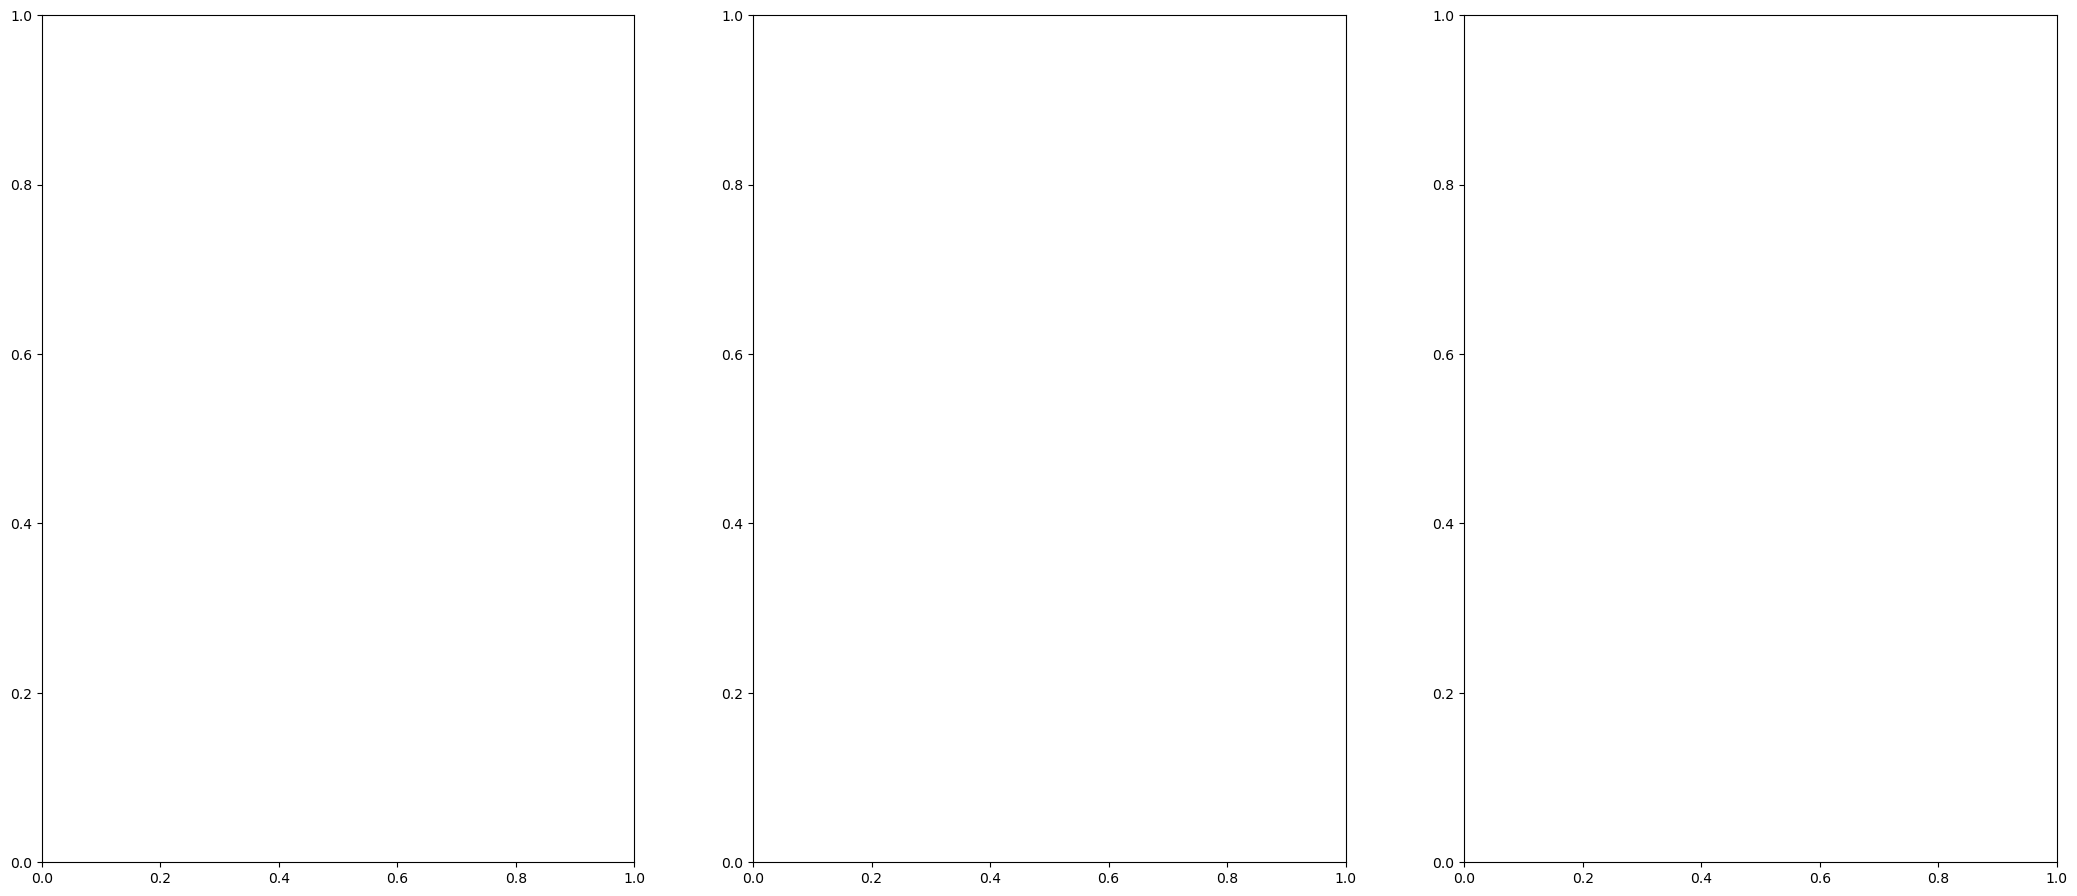

In [8]:
%%time

importlib.reload(mypy) # Required because I am constantly editing .py files
importlib.reload(mycase) 
importlib.reload(myfigs) 

# Mean/Nino/Nina regional profiles
mp.figure(3)
fign, axn = mp.subplots(1,3,figsize=(26, 11))  
fign.patch.set_facecolor('white') # Sets the plot background outside the data area to be white. Remove to make it transparent.




'''
########################
##### LOOP CASES  ######
########################
'''


for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
    
    lclimo = True if reanal_climo and case_type[icase] == 'reanal' else False
   
    
    print('')
    print('')
    print('')
    print('**** **** **** **** **** **** **** **** **** ')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('**** **** **** **** **** **** **** **** **** ')
    print('- Name = ',case,' ->',sim_name)
    print('**** **** **** **** **** **** **** **** **** ')
    print('')   
    
    
    ## Read data in from files ##

 
    print('-- SET TIME RANGE OF TIMESERIES DATA -- ',yr0,' to ',yr1)
    print('')
    print('-- Grabbing variable files --')
    
    if lclimo:  # Read in tseries based files here for the analysis variable
        files_ptr,var_name   = mypy.get_files_climo(sim_name,case_type[icase],var_cam,years_data) # Grab variable
    else :
        files_ptr,var_name   = mypy.get_files_tseries(sim_name,case_type[icase],var_cam,years_data) # Grab variable
    
    
   
    ## TS FROM HISTORY FILES (just copy for h0 files if they are already read in)
    ## Can still do this for lclimo as it will take observed if reanal

    print('-- Grabbing SST files --')
    
    if case_type[icase] in ['cam6_revert']: # I think this effectively acts as a pointer, I hope!
        tfiles_ptr = files_ptr 
        tvar_name = 'TS'
    else :   
        tfiles_ptr,tvar_name = mypy.get_files_tseries(sim_name,case_type[icase],'TS',years_data) # Grab TS for nino timeseries


# Grabbing PS if needed

    print('-- Grabbing PS files --')
    
    if case_type[icase] in ['cam6_revert']: # Grab the LENS time series or just use existing file_ptr from h0 type output.
        pfiles_ptr = files_ptr 
    else:
        if not lclimo: # Don't need to read in PS for climos.
            pfiles_ptr,pvar_name = mypy.get_files_tseries(sim_name,case_type[icase],'PS',years_data) # Grab TS for nino timeseries
        
        

    ''' TRIM FOR SPECIFIED YEARS '''
    
   
    print('-- Calculating and plotting nino SST anomalies - this will never be climo currently')

    sst_data = tfiles_ptr[tvar_name].sel(lat=slice(lats_in,latn_in),time=slice(str(yr0), str(yr1)))

    
    
    ''' SST ANOMALY ROUTINE ARRAY '''
  
    sst_months =  sst_data.time.dt.strftime("%b")    
    inino_mons,inina_mons = mypy.nino_sst_anom(sim_name,sst_data,nino_region,dir_proot)
    
    print('-- NINO grab:  Done --')
   
    
    
    
 

    
 
   
        
# Just read in the season months and levs we need
    
 
    if not lclimo:
        
        
 
        ''' Trim datasets for lev/lat/time for simplicity '''

# Grab time/lev coord.
 
        lev = files_ptr['lev'].sel(lev=slice(min(p_levs),max(p_levs)))

# Trimming as much as possible time/lat/lev        
     
        files_ptr=files_ptr.sel(lat=slice(lats_in,latn_in),time=slice(str(yr0),str(yr1)),lev=slice(min(p_levs),max(p_levs)))
        pfiles_ptr=pfiles_ptr.sel(lat=slice(lats_in,latn_in),time=slice(str(yr0),str(yr1)))       
       
        
# Grab variables
        var_in = files_ptr[var_name]
        ps_in = pfiles_ptr['PS']
        time_in = files_ptr.time
        
# Calculate dp        
        dp_lev = np.diff(lev)

    
# Array accessing based on type of case.    
        if case_type[icase] in ['lens1','lens2','c6_amip']:
            print('-- "Compute" the variable array now (bring it up from lazy array) if != ANALYSES')
#            %time var_in = var_in.compute()



        
      

# Check SST size with Variable size

        if sst_data.time.size != time_in.size : print('SST and VARIABLE sizes DO NOT MATCH - ',sst_data.time.size,' and ',time_in.size) 

        month_nums = time_in.dt.month   
        hmonths = time_in.dt.strftime("%b")



        lmon_seas = np.isin(hmonths,seas_mons) # Logical for season months in all months
        imon_seas = np.argwhere(lmon_seas)[:,0] # Indices
        hmon_seas = hmonths[imon_seas] # Subsetting full months.



    ## Much easier than above but doing the intersections of months and nino months.
        inino_seas,inino_ind,imon_nino_ind = np.intersect1d(inino_mons, imon_seas, return_indices=True)
        inina_seas,inina_ind,imon_nina_ind = np.intersect1d(inina_mons, imon_seas, return_indices=True)


    ## Could speed up below by reading in var_in for the season months then subsetting that for nino/nina    
    ## Remember: It is reading in a subset of seaonal months and then nino/nina are a subset of those. 

        var_in_inseas = var_df.loc[var_cam]['vscale']*var_in[imon_seas,:,:,:] # Pull only the months we need
        var_ps_inseas = ps_in[imon_seas,:,:] 

        if case_type[icase] in ['reanal','cam6_revert']:
            print('-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES')
            %time var_in_inseas = var_in_inseas.compute()

        var_in_seas = var_in_inseas.mean(dim=['time'])  # Perform seasonal average
        var_ps_seas = var_ps_inseas.mean(dim=['time'])  # 

# Nino/nina averages
        var_in_nino = var_in_inseas[imon_nino_ind,:,:,:].mean(dim=['time'])  # Take nino/nina months from the seasonal timeseries months
        var_in_nina = var_in_inseas[imon_nina_ind,:,:,:].mean(dim=['time']) 
        
# Nino/nina anomalies
        var_in_nino = var_in_nino-var_in_seas
        var_in_nina = var_in_nina-var_in_seas
        
        var_ps_nino = var_ps_inseas[imon_nino_ind,:,:].mean(dim=['time'])  # Take nino/nina months from the seasonal timeseries months
        var_ps_nina = var_ps_inseas[imon_nina_ind,:,:].mean(dim=['time']) 
  
        varp_in_ps = (var_ps_seas,var_ps_nino,var_ps_nina) 
    
       
    
    else :    ### Just grab separate data from climo, nino and nina files.
        
        var_in_seas =  files_ptr[var_name].isel(time=0).sel(lat=slice(lats_in,latn_in))
        var_in_nino =  files_ptr[var_name].isel(time=1).sel(lat=slice(lats_in,latn_in))
        var_in_nina =  files_ptr[var_name].isel(time=2).sel(lat=slice(lats_in,latn_in))
        
        
        lev_in = var_in_seas.lev
        ilevs = np.where(lev_in >= min(p_levs))

        lev = lev_in[ilevs]

  
        var_in_seas =  var_df.loc[var_cam]['ovscale']*var_in_seas.loc[lev[0]:lev[-1]]
        var_in_nino =  var_df.loc[var_cam]['ovscale']*var_in_nino.loc[lev[0]:lev[-1]]
        var_in_nina =  var_df.loc[var_cam]['ovscale']*var_in_nina.loc[lev[0]:lev[-1]]
        
        
        varp_in_ps = None
    

  



    '''
        ####################################    
        ### Plot div/omega level ###
        ####################################
    '''     

    if l_pminmax_plev:
        print('-- Plotting max/min pressure level of field --')
        mp.figure(2)
        varp_in_lev = (var_in_seas,var_in_nino,var_in_nina) # Put in tuple for looping.
        pdiv_lev = myfigs.plot_div_pres(case_type[icase],case,var_cam,varp_in_lev,varp_in_ps,files_ptr,dir_proot,ldiv)


        
        
        

    '''
        ########################    
        ### Now Loop Regions ###
        ########################
    ''' 
    
    mp.figure(3)
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##

### Assign lat/lon region domain ###

        reg_name = reg_df.loc[reg]['long_name'] 
    
#        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
#        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print()
        print('-- Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0E %.1f-%d\u00b0N' % (reg_w,reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dE_%.1f-%dN' % (reg_w,reg_e,reg_s,reg_n)  
         
        print('-- Averaging for region - ',reg_a_str)

        
        
        
### Compute Seasonal/El Nino/La Nina profiles ###
         
        varp_seas = var_in_seas.loc[:,reg_s:reg_n,reg_w:reg_e]
        
#        if lclimo :
            
        varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]
        varp_nina = var_in_nina.loc[:,reg_s:reg_n,reg_w:reg_e]
        
#        else :
        
#         varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
#         varp_nina = var_in_nina.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        
        varp_all = (varp_seas,varp_nino,varp_nina) # Put in tuple for looping.
               
        
    
            
            
            
        '''
        ####################################    
        ### Loop climo/nino/nina periods ###
        ####################################
        '''     
        
## LOOP: Seasonal/El Nino/La Nina plots for this region.
 
        
        for iplot,var_plot in enumerate(varp_all):
            
            print('    -- Period = '+nino_names[iplot])
            pxmin = xmin if iplot == 0 else axmin
            pxmax = xmax if iplot == 0 else axmax
            
# Regional average
            var_fig = var_plot.mean(dim=['lat','lon'],skipna = True)   
        
        
           
            
            if ldiv and var_cam == 'OMEGA':
                var_fig = var_fig.differentiate("lev")
                
    
            axn[iplot].plot(var_fig,lev,lw=lwidth[icase],markersize=9,marker=pmark[icase],color=lcolor[icase],linestyle=lstyle[icase])  
 


            if (icase==0) :
                axn[iplot].set_title(nino_names[iplot],fontsize=20,color=nino_colors[iplot])
                axn[iplot].set_xlim([pxmin,pxmax])
                axn[iplot].set_ylim([ppmax,ppmin])
                axn[iplot].set_ylabel('mb',fontsize=16) 
                axn[iplot].set_xlabel(vunits,fontsize=16)      
                axn[iplot].set_yticks(p_levs)
                axn[iplot].set_yticklabels(p_levs,fontsize=14)
###                axn[iplot].set_xticklabels(np.arange(xmin,xmax,0.1*(xmax-xmin)),fontsize=12)
                axn[iplot].tick_params(axis='both', which='major', labelsize=14)

                axn[iplot].grid(linestyle='--')  
                
    
            if ((pxmin < 0) and (pxmax > 0)) :
                axn[iplot].vlines(0., ppmax, ppmin, linestyle="--",lw=1, color='black')

             
    
# Legend ### Perform a bit of logic for the  
#rtypes, counts = np.unique(case_type, return_counts=True)


lloc = 'lower right' if var_name in ['ZMDQ','STEND_CLUBB'] else 'lower left' 
#axn[0].legend(leg_cases,fontsize=15,loc = lloc)

axn[0].legend(leg_elements,leg_labels,fontsize=15,loc = lloc)

# Main title
fign.suptitle('ENSO Anomalies - '+reg_name+' -- '+reg_a_str+' - '+var_text,fontsize=20)

mp.rcParams['xtick.labelsize'] = 15 # Global set of xtick label size    

    
#    mp.show()





# Hard copy  
fign.savefig(dir_proot+pref_out+'_nino_vprof_'+var_pname+'_'+reg_a_out+'_'+str(yr0)+'_to_'+str(yr1)+'.png', dpi=80)

#mp.show()   

print()
print()
print('-- End Timing --')